**Health Care Data Analysis**
**Group 8 - Project 9 -- HealthCare Data Analytics with Pyspark**

In [1]:
#Importing all neccesary Modules
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, to_date, lit, mean, stddev, count, regexp_replace, initcap, round, datediff
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Creating a Spark session
spark = SparkSession.builder \
    .appName("Healthcare Data Analysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

<strong>Data Collection and Loading (Data Taken from Kaggle)</strong>

In [3]:
#Reading the data and dropping the duplicates comparing all columns
df = spark.read.csv("C://Pyspark Project//healthcare_data_streamlit.csv", header=True, inferSchema=True)

**Data Preprocessing**

In [4]:
#Dropping the duplicate columns
df = df.dropDuplicates()

In [5]:
# Rename columns to remove spaces
new_column_names = [col(c).alias(c.replace(" ", "_")) for c in df.columns]
df = df.select(*new_column_names)

In [6]:
# Convert column names to camel case
def to_camel_case(column_name):
    return initcap(regexp_replace(column_name, "_+", " "))

df = df.withColumn("Name", to_camel_case(col("Name")))

In [7]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood_Type: string (nullable = true)
 |-- Medical_Condition: string (nullable = true)
 |-- Date_of_Admission: string (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance_Provider: string (nullable = true)
 |-- Billing_Amount: double (nullable = true)
 |-- Room_Number: integer (nullable = true)
 |-- Admission_Type: string (nullable = true)
 |-- Discharge_Date: string (nullable = true)
 |-- Test_Results: string (nullable = true)
 |-- Readmission: string (nullable = true)
 |-- Survived: string (nullable = true)



In [8]:
# Convert date columns to datetime
df = df.withColumn("Date_of_Admission", to_date(col("Date_of_Admission"), "MM/dd/yyyy"))
df = df.withColumn("Discharge_Date", to_date(col("Discharge_Date"), "MM/dd/yyyy"))

In [9]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood_Type: string (nullable = true)
 |-- Medical_Condition: string (nullable = true)
 |-- Date_of_Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance_Provider: string (nullable = true)
 |-- Billing_Amount: double (nullable = true)
 |-- Room_Number: integer (nullable = true)
 |-- Admission_Type: string (nullable = true)
 |-- Discharge_Date: date (nullable = true)
 |-- Test_Results: string (nullable = true)
 |-- Readmission: string (nullable = true)
 |-- Survived: string (nullable = true)



In [10]:
# Round billing amount to 2 decimal places
df = df.withColumn("Billing_Amount", round(col("Billing_Amount"), 2))

In [11]:
# Calculate length of stay
df = df.withColumn("Length_of_Stay", datediff(col("Discharge_Date"), col("Date_of_Admission")))

**Data Quality Checks**

In [13]:
# EDA: Missing Values
pandas_df = df.toPandas()
print("Missing Values:")
print(pandas_df.isnull().sum())

Missing Values:
Name                  0
Age                   0
Gender                0
Blood_Type            0
Medical_Condition     0
Date_of_Admission     0
Doctor                0
Hospital              0
Insurance_Provider    0
Billing_Amount        0
Room_Number           0
Admission_Type        0
Discharge_Date        0
Test_Results          0
Readmission           0
Survived              0
Length_of_Stay        0
dtype: int64


**Exploratory Data Analysis(EDA)**

In [14]:
# Calculate basic summary statistics
summary_stats = df.select(
    count("*").alias("count"),
    round(mean("Age"), 2).alias("mean_age"),
    round(mean("Length_of_Stay"), 2).alias("mean_length_of_stay"),
    round(mean("Billing_Amount"), 2).alias("mean_billing_amount"),
    round(stddev("Age"), 2).alias("stddev_age"),
    round(stddev("Length_of_Stay"), 2).alias("stddev_length_of_stay"),
    round(stddev("Billing_Amount"), 2).alias("stddev_billing_amount")
)
summary_stats.show(truncate=False)

+-----+--------+-------------------+-------------------+----------+---------------------+---------------------+
|count|mean_age|mean_length_of_stay|mean_billing_amount|stddev_age|stddev_length_of_stay|stddev_billing_amount|
+-----+--------+-------------------+-------------------+----------+---------------------+---------------------+
|3492 |52.06   |15.36              |25569.2            |19.78     |8.66                 |14219.1              |
+-----+--------+-------------------+-------------------+----------+---------------------+---------------------+



In [15]:
# Calculate median for numerical columns without rounding
median_age = df.approxQuantile("Age", [0.5], 0.01)[0]
median_billing = df.approxQuantile("Billing_Amount", [0.5], 0.01)[0]
median_length_of_stay = df.approxQuantile("Length_of_Stay", [0.5], 0.01)[0]

print(f"Median Age: {median_age}")
print(f"Median Billing Amount: {median_billing}")
print(f"Median Length of Stay: {median_length_of_stay}")

Median Age: 51.0
Median Billing Amount: 24977.27
Median Length of Stay: 15.0


**Data Aggregartion and Grouping**

In [16]:
# Group by patient demographics and calculate average length of stay
df.groupBy("Age", "Gender").agg(round(mean("Length_of_Stay"), 2).alias("Average_Length_of_Stay")).show()

+---+------+----------------------+
|Age|Gender|Average_Length_of_Stay|
+---+------+----------------------+
| 61|Female|                 17.03|
| 19|Female|                 15.43|
| 70|  Male|                 14.58|
| 77|Female|                 15.42|
| 56|Female|                 16.96|
| 76|Female|                 16.67|
| 48|  Male|                 17.67|
| 53|  Male|                  16.0|
| 47|  Male|                 15.56|
| 26|  Male|                 17.75|
| 32|  Male|                 15.67|
| 55|Female|                 16.12|
| 64|  Male|                 12.12|
| 65|Female|                 13.75|
| 82|  Male|                 16.74|
| 25|  Male|                 16.38|
| 78|Female|                 15.17|
| 79|  Male|                 14.17|
| 24|  Male|                 15.52|
| 38|Female|                 13.85|
+---+------+----------------------+
only showing top 20 rows



In [17]:
# Group by hospital and calculate readmission rate
df.groupBy("Hospital").agg(round(mean(when(col("Readmission") == "Yes", 1).otherwise(0)), 2).alias("Readmission_Rate")).show()

+--------------------+----------------+
|            Hospital|Readmission_Rate|
+--------------------+----------------+
|Holmes Reed and J...|             0.0|
|     Alvarado-Martin|             1.0|
|        Lopez-Wilson|             1.0|
|          LLC Massey|             0.0|
|and Mayo Chen, Mu...|             0.0|
|         Group Stein|             0.0|
|and Lee Rodriguez...|             0.0|
|           Smith PLC|             0.0|
|     Dawson-Williams|             0.0|
|     Coleman-Aguilar|             0.0|
|          Hall Group|             0.0|
|      Harris-Farrell|             0.0|
|Foster Lamb, Grah...|             1.0|
|    Ramirez-Robinson|             1.0|
|Jones, Walker Moo...|             0.0|
|       Medina-Campos|             1.0|
|           PLC Kelly|             1.0|
|      Romero-Sanchez|             0.0|
|         Fox-Anthony|             0.0|
|and Neal Vargas, ...|             1.0|
+--------------------+----------------+
only showing top 20 rows



In [18]:
# Group by diagnosis type and calculate average length of stay
df.groupBy("Medical_Condition").agg(round(mean("Length_of_Stay"), 0).alias("Average_Length_of_Stay")).show()

+-----------------+----------------------+
|Medical_Condition|Average_Length_of_Stay|
+-----------------+----------------------+
|          Obesity|                  16.0|
|         Diabetes|                  15.0|
|        Arthritis|                  15.0|
|     Hypertension|                  15.0|
|           Cancer|                  16.0|
|           Asthma|                  16.0|
+-----------------+----------------------+



In [19]:
# Group by medical condition and calculate readmission rate
df.groupBy("Medical_Condition").agg(round(mean(when(col("Readmission") == "Yes", 1).otherwise(0)), 2).alias("Readmission_Rate")).show()

+-----------------+----------------+
|Medical_Condition|Readmission_Rate|
+-----------------+----------------+
|          Obesity|            0.39|
|         Diabetes|            0.42|
|        Arthritis|            0.38|
|     Hypertension|             0.4|
|           Cancer|            0.42|
|           Asthma|            0.43|
+-----------------+----------------+



In [20]:
# Group by medical condition and calculate mortality rate
df.groupBy("Medical_Condition").agg(round(mean(when(col("Survived") == "No", 1).otherwise(0)), 2).alias("Mortality_Rate")).show()

+-----------------+--------------+
|Medical_Condition|Mortality_Rate|
+-----------------+--------------+
|          Obesity|          0.15|
|         Diabetes|          0.17|
|        Arthritis|          0.18|
|     Hypertension|           0.2|
|           Cancer|          0.15|
|           Asthma|          0.18|
+-----------------+--------------+



**Additional Analysis Possibilities**

In [21]:
# Distribution of patients by blood type
df.groupBy("Blood_Type").count().show()

+----------+-----+
|Blood_Type|count|
+----------+-----+
|       AB+|  452|
|        O+|  457|
|       AB-|  446|
|        A-|  424|
|        O-|  423|
|        B+|  428|
|        A+|  451|
|        B-|  411|
+----------+-----+



In [22]:
# Average billing amount by insurance provider
df.groupBy("Insurance_Provider").agg(round(mean("Billing_Amount"), 2).alias("Average_Billing_Amount")).show()

+------------------+----------------------+
|Insurance_Provider|Average_Billing_Amount|
+------------------+----------------------+
|             Aetna|              25063.23|
|        Blue Cross|              25975.92|
|          Medicare|              25917.54|
|             Cigna|              25412.74|
|  UnitedHealthcare|              25444.83|
+------------------+----------------------+



**Data Visualization**

In [23]:
pandas_df = df.toPandas()

In [24]:
print("Summary Statistics:")
print(pandas_df.describe())

Summary Statistics:
               Age  Billing_Amount  Room_Number  Length_of_Stay
count  3492.000000     3492.000000  3492.000000     3492.000000
mean     52.064719    25569.201203   296.654639       15.362829
std      19.781341    14219.098402   115.920984        8.664426
min      18.000000       42.510000   101.000000        1.000000
25%      36.000000    13308.672500   197.000000        8.000000
50%      52.000000    25502.190000   296.000000       15.500000
75%      70.000000    37761.165000   395.000000       23.000000
max      85.000000    52181.840000   500.000000       30.000000


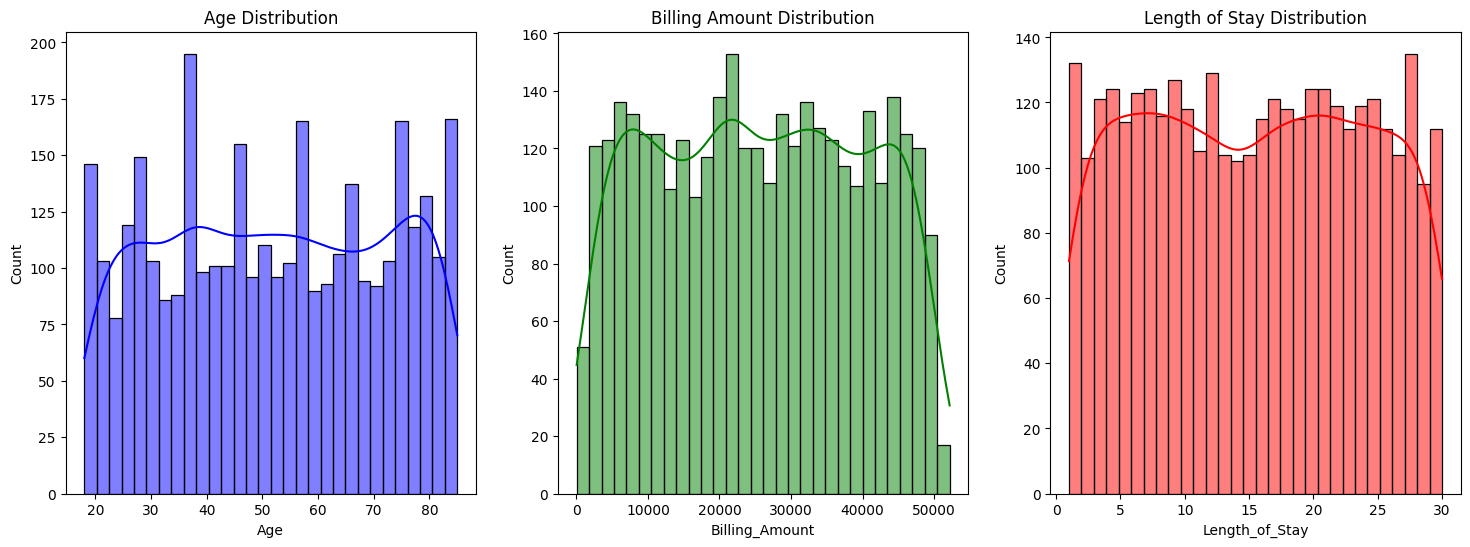

In [25]:
# EDA: Distribution Plots
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(pandas_df['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.subplot(1, 3, 2)
sns.histplot(pandas_df['Billing_Amount'], bins=30, kde=True, color='green')
plt.title('Billing Amount Distribution')
plt.subplot(1, 3, 3)
sns.histplot(pandas_df['Length_of_Stay'], bins=30, kde=True, color='red')
plt.title('Length of Stay Distribution')
plt.show()

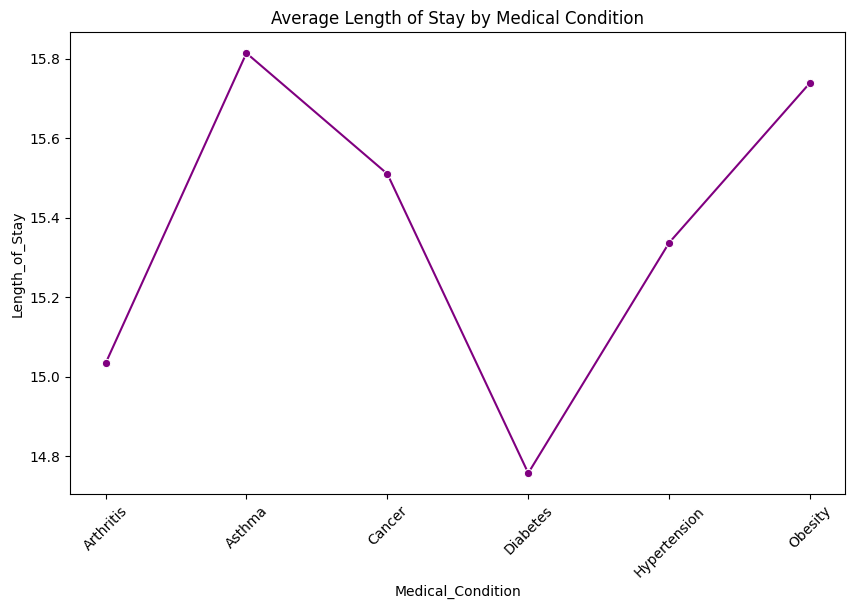

In [26]:
# Line Chart: Average Length of Stay by Medical Condition
plt.figure(figsize=(10, 6))
avg_length_of_stay = pandas_df.groupby('Medical_Condition')['Length_of_Stay'].mean().reset_index()
sns.lineplot(x='Medical_Condition', y='Length_of_Stay', data=avg_length_of_stay, marker='o', color='purple')
plt.xticks(rotation=45)
plt.title('Average Length of Stay by Medical Condition')
plt.show()

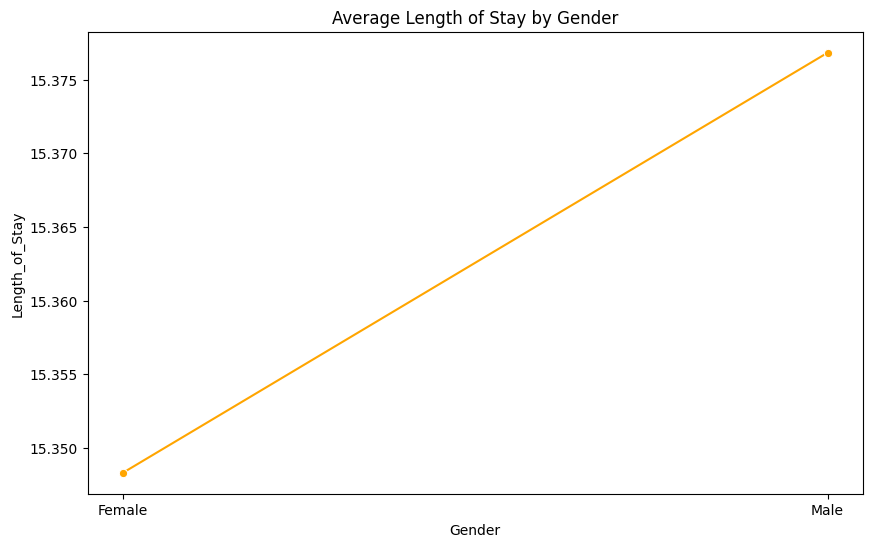

In [27]:
# Line Chart: Average Length of Stay by Gender
plt.figure(figsize=(10, 6))
avg_length_of_stay_gender = pandas_df.groupby('Gender')['Length_of_Stay'].mean().reset_index()
sns.lineplot(x='Gender', y='Length_of_Stay', data=avg_length_of_stay_gender, marker='o', color='orange')
plt.title('Average Length of Stay by Gender')
plt.show()

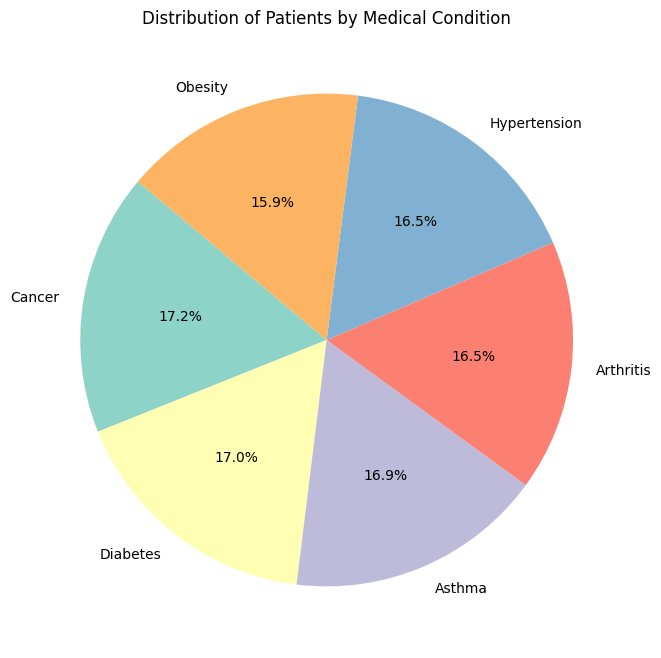

In [28]:
# Pie Chart: Distribution of Patients by Medical Condition
plt.figure(figsize=(8, 8))
medical_condition_distribution = pandas_df['Medical_Condition'].value_counts()
plt.pie(medical_condition_distribution, labels=medical_condition_distribution.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title('Distribution of Patients by Medical Condition')
plt.show()

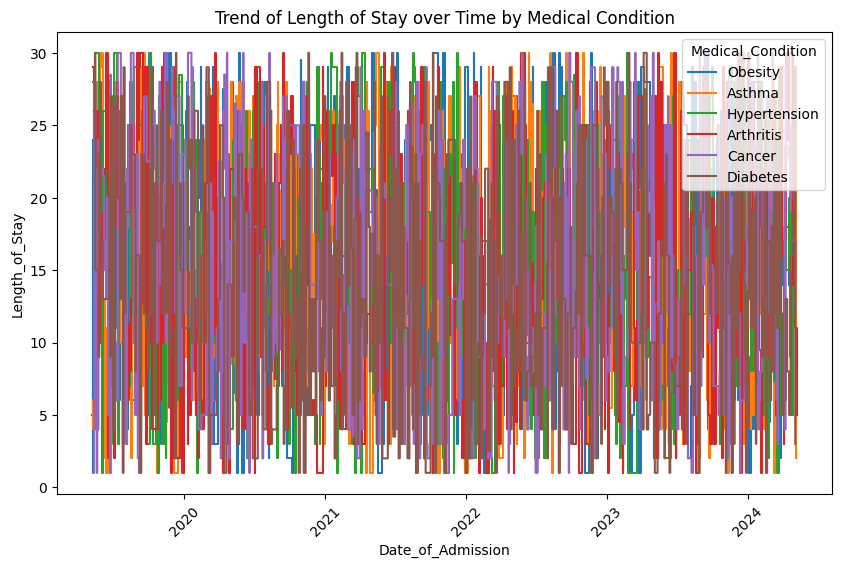

In [29]:
# Step Plot: Trend of Length of Stay over Time by Medical Condition
plt.figure(figsize=(10, 6))
pandas_df['Date_of_Admission'] = pd.to_datetime(pandas_df['Date_of_Admission'])
length_of_stay_trend = pandas_df.groupby(['Date_of_Admission', 'Medical_Condition'])['Length_of_Stay'].mean().reset_index()
sns.lineplot(x='Date_of_Admission', y='Length_of_Stay', hue='Medical_Condition', data=length_of_stay_trend, palette='tab10', drawstyle='steps-post')
plt.xticks(rotation=45)
plt.title('Trend of Length of Stay over Time by Medical Condition')
plt.show()

C:\Users\gokul\AppData\Local\Temp\ipykernel_54044\954170537.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Medical_Condition', y='Length_of_Stay', data=pandas_df, palette='Set2')


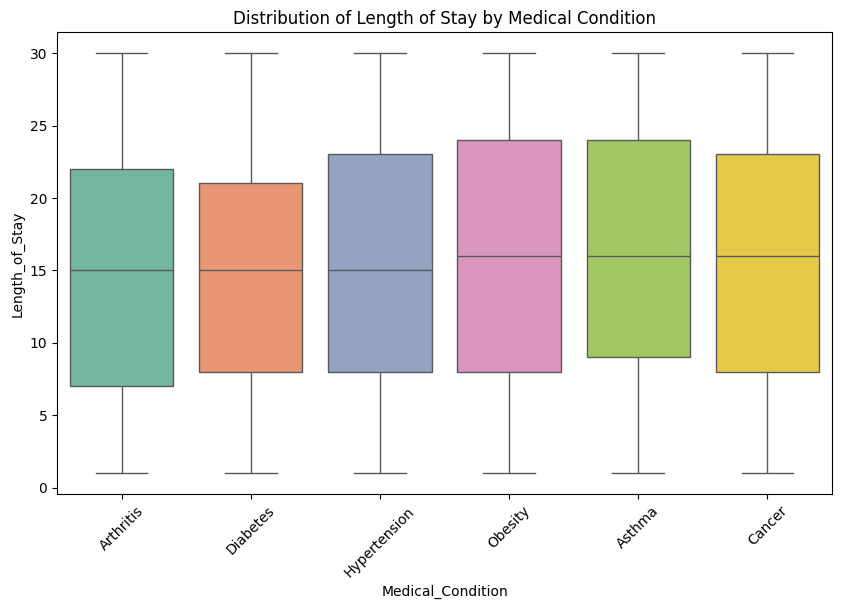

In [30]:
# Box Plot: Distribution of Length of Stay by Medical Condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Medical_Condition', y='Length_of_Stay', data=pandas_df, palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribution of Length of Stay by Medical Condition')
plt.show()

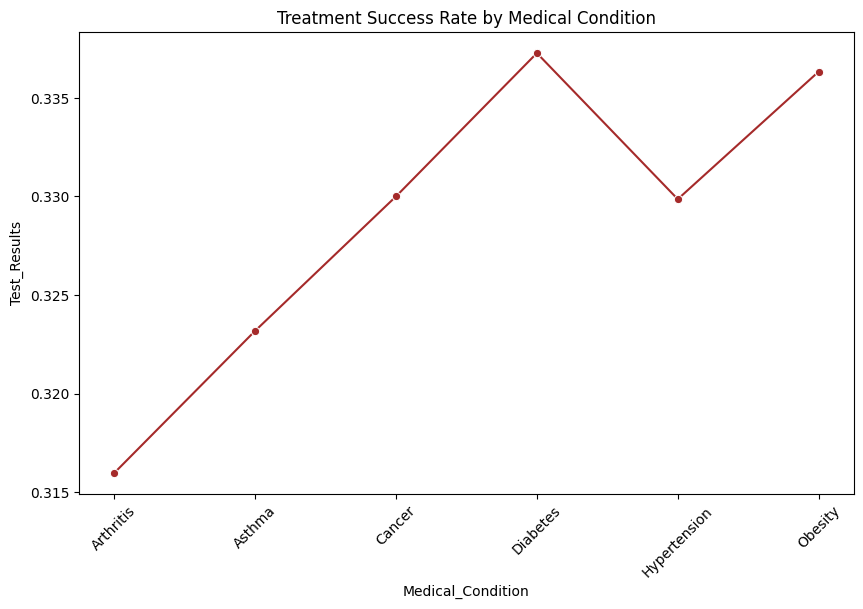

In [31]:
# Line Chart: Treatment Success Rate by Medical Condition
treatment_success_rate = pandas_df.groupby('Medical_Condition')['Test_Results'].apply(lambda x: (x == 'Normal').mean()).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Medical_Condition', y='Test_Results', data=treatment_success_rate, marker='o', color='brown')
plt.xticks(rotation=45)
plt.title('Treatment Success Rate by Medical Condition')
plt.show()

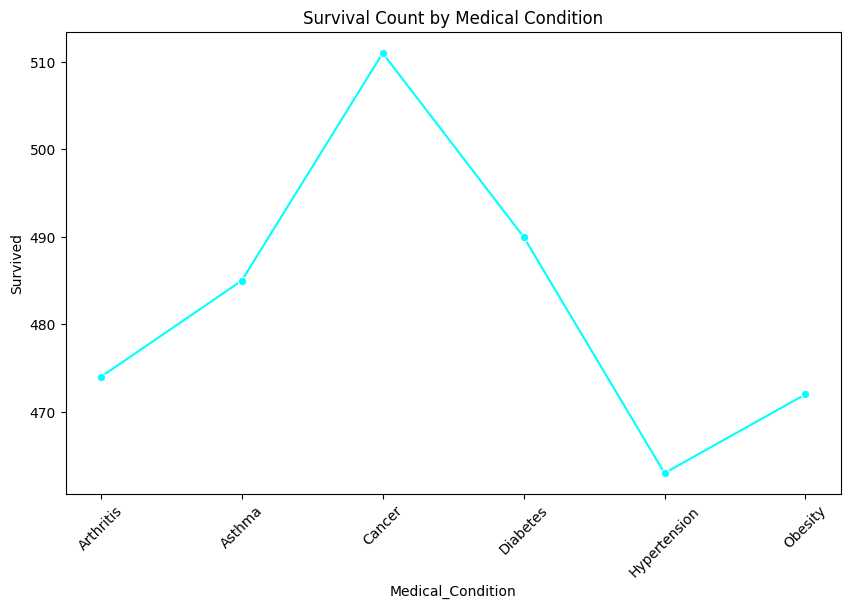

In [32]:
# Line Chart: Survival Count by Medical Condition
survival_count = pandas_df.groupby('Medical_Condition')['Survived'].apply(lambda x: (x == 'Yes').sum()).reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Medical_Condition', y='Survived', data=survival_count, marker='o', color='cyan')
plt.xticks(rotation=45)
plt.title('Survival Count by Medical Condition')
plt.show()

<function matplotlib.pyplot.xticks(ticks: 'ArrayLike | None' = None, labels: 'Sequence[str] | None' = None, *, minor: 'bool' = False, **kwargs) -> 'tuple[list[Tick] | np.ndarray, list[Text]]'>

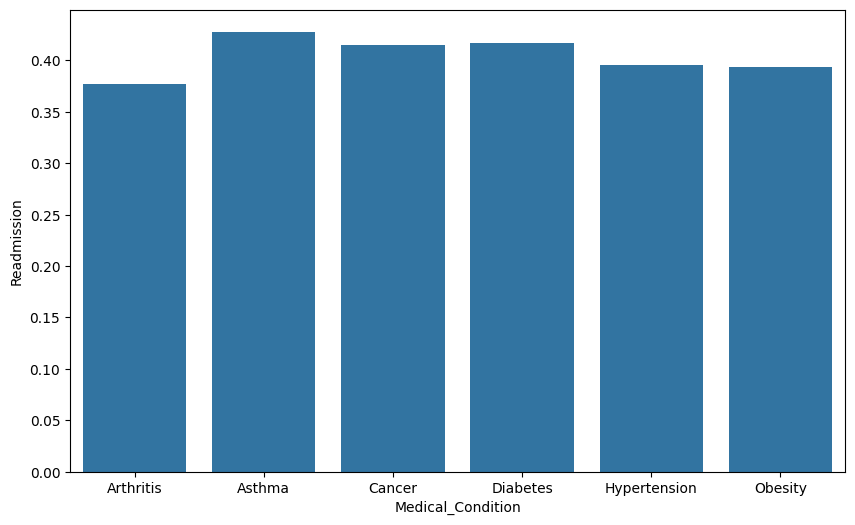

In [33]:
# Bar Chart: Readmission Rate by Medical Condition
readmission_rate = pandas_df.groupby('Medical_Condition')['Readmission'].apply(lambda x: (x == 'Yes').mean()).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='Medical_Condition', y='Readmission', data=readmission_rate)
plt.xticks